# Crystal Electric Field (CF) Analysis of the Pr4+ ion
Here the goal is to use collected inelastic neutron scattering (INS) data to determine the ground state crystal field Hamiltonian. The Stevens' coefficients first guess comes from the grid search. I use PyCrystalField in conjunction with LMFIT to find the true values of the Stevens' Coefficients by fitting predicted energy levels to measured one. I then calculate the CF Hamiltonian and predict the compounds thermodynamic properties. Magnetization (M vs H) and Susceptibility (M vs T) data. 

It's important to note that I don't actually use Pr4+ as my central ion, I use Ce3+. The correct orbital values for the Ln4+ oxidized states have not been calculated and tabulated. Since the operators depend on electronic orbital states, I can use an electrically equivalent ion, Ce3+, instead of the actual Pr4+ ion.

In [1]:
%reload_ext autoreload
import sys
sys.path.append('..')
from JensenTools import *
from lmfit import Model
import PyCrystalField as cef
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
seaborn.set()

#Simple function for pritting my parameters after fitting so that I can copy paste the values from output for further iterations
def paramPrint(fittedparams):
	print()
	for i in fittedparams:
		# print(i, ' = ', i.value)
		print(i, ' = ',fittedparams[i].value )

 *******************************************************
 *                PyCrystalField 2.3.1                 *
 *  Please cite  J. Appl. Cryst. (2021). 54, 356-362   * 
 *    <https://doi.org/10.1107/S160057672001554X>      *
 *******************************************************



##  My Energy Calculation Function To Be Used As An LMFIT Model

In [2]:
def energyFit(B20, B40, B44, B60,B64, LS, numlevels **kwargs ):
# 	numlevels = numlevels
	Stev = {} #Creating the Stevens' Coefficients dictionary and assigning values
	Stev['B20'] = B20
	Stev['B40'] = B40
	Stev['B60'] = B60
	Stev['B44'] = B44
	Stev['B64'] = B64

	if kwargs['LS_on']:
		Pr = cef.LS_CFLevels.Bdict(Bdict=Stev, L=3, S=0.5, SpinOrbitCoupling = LS) #Create CF_Levels obejct wtih the given coefficients.
		Pr.diagonalize()
		if kwargs['Kmeans']:
			e = kmeansSort(Pr.eigenvalues,numlevels)[:3] #Excluding the highest mode which we did not detect in our INS runs
			# e.append(e[2]/e[1]) #The aforementioned ratio
		else: 
			e = Pr.eigenvalues
	else:
		Pr = cef.CFLevels.Bdict(Bdict = Stev, ion = kwargs['ion'])
		Pr.diagonalize()
		if kwargs['Kmeans']:   	
			e = kmeansSort(Pr.eigenvalues,numlevels) #Excluding the highest mode which we did not detect in our INS runs
		else:
			e =  Pr.eigenvalues
	return e

## Define the important things

In [3]:
#Define important things
#####################################################################################################################################################################
comp = 'Sr2PrO4'
ion = 'Ce3+'
who = 'Arun'
LS_on = True
Kmeans = True
LSValue = 100
numlevels = 4
# The L,S values are as follows for the Pr4+ ion
L = 3
S = 0.5
Emeas = [168, 335,385] #The measured INS magnetic modes. The last entry being a ratio
#####################################################################################################################################################################

In [4]:
saveDir = getSaveDir('m',comp = comp)
MHDir = getSaveDir('m',comp = comp, dataType = 'MH')
MTDir = getSaveDir('m',comp = comp, dataType = 'MT')

## LMFIT Model Creation

In [5]:
#From GridSearch For LS
#####################################################################################################################################################################
# LS = LSValue
# x =  0.03629536921151444
# bpf = -0.6570713391739674
# # Assigning the coefficients from grid search
# # Enforcing cubic constraints as a start
# # and including the B20 term which is needed for tetragonal symmetry
# B40 = bpf
# B60 = x*bpf
# B44 = 5*B40
# B64 = -21*B60
# B20 = 0
#####################################################################################################################################################################

#####################################################################################################################################################################
eModel = Model(energyFit, independent_vars = ['numlevels'])
params = eModel.make_params()
B40  =  -0.6568663783690575
B60  =  -0.02328250024945387
LS  =  100.00007580463522
B44  =  -3.1415463304732714
B64  =  0.504906552605772
B20  =  0.4858075931009187
# Since we only have 4 training points, only 4 parameters can vary at once.
params['B20'].set(value = B20, vary = True)
params['B40'].set(value=B40, vary=True)
params['B60'].set(value=B60, vary=True)
params['B44'].set(value = B44, vary = False )
params['B64'].set(value = B64, vary = False )
params['LS'].set(value=LS, vary=False)
#Fit model to data
fitted = eModel.fit(Emeas,params, numlevels = 4 , LS_on = LS_on, Kmeans = Kmeans)
#Create a dictionary of the fitted parameters (stevens coefficients)
stev = {'B40': fitted.params['B40'].value, 'B60': fitted.params['B60'].value, 'B44' : fitted.params['B44'].value, 'B64' : fitted.params['B64'].value, 'B20' :fitted.params['B20'].value }
#####################################################################################################################################################################


In [6]:
#Print the parameters and reduced chi sqr value
print('\n\nFitted parameters:')
fitted.params.pretty_print()
print('\nReduced Chi Sqr = {}'.format(fitted.result.redchi))
#Uncomment to print out in easy copy paste format
paramPrint(fitted.params)



Fitted parameters:
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
B20    0.4858     -inf      inf    0.153     True     None     None
B40   -0.6569     -inf      inf 0.005617     True     None     None
B44    -3.142     -inf      inf        0    False     None     None
B60  -0.02328     -inf      inf 0.0001991     True     None     None
B64    0.5049     -inf      inf        0    False     None     None
LS        100     -inf      inf        0    False     None     None

Reduced Chi Sqr = 1.093852592025145

B40  =  -0.6568663783690575
B60  =  -0.02328250024945387
B44  =  -3.1415463304732714
B64  =  0.504906552605772
B20  =  0.4858075931009187
LS  =  100.00007580463522


## Best fit results.
### Since there are more features than training points, I let a few coefficients vary freely, lock in those values, then let the others vary. The values below are after a few iterations,  produced some of the best results.

## Set the LMFIT parameters and use it to fit to the previously given energies.

## Use our fitted B parameters to obtain the CF Hamiltonian

In [7]:
#CF Analysis
#####################################################################################################################################################################
#Create the CFLevels object and diagonalize it
if LS_on:
	Pr = cef.LS_CFLevels.Bdict(Bdict = stev, L = L, S = S, SpinOrbitCoupling=fitted.params['LS'].value)
	Pr.diagonalize()
else:
	Pr = cef.CFLevels.Bdict(Bdict = stev, ion = 'Ce3+')
	Pr.diagonalize()
	

#Print final matrix
print('\n\nEnergy values as measured by INS (meV): {}'.format(Emeas[:-1]))
Pr.printEigenvectors()

#Calculate and neatly print G-Tensor using Pandas
gt = Pr.gtensor()
rows = ['gx','gy','gz']
df = pd.DataFrame(gt, columns = rows, index = rows)
print(df)
#####################################################################################################################################################################



Energy values as measured by INS (meV): [168, 335]

 Eigenvalues 	 Eigenvectors
		---------------------------------------------------------------------------------------------------------
0.00000 	|  [ 0.     0.     0.     0.     0.    -0.706  0.706  0.     0.     0.
  0.     0.     0.    -0.055]  |
0.00000 	|  [ 0.055  0.     0.     0.     0.     0.     0.    -0.706  0.706  0.
  0.     0.     0.     0.   ]  |
14.68320 	|  [ 0.     0.     0.    -0.3    0.277  0.     0.     0.     0.     0.
  0.    -0.302  0.862  0.   ]  |
14.68320 	|  [ 0.    -0.862  0.302  0.     0.     0.     0.     0.     0.    -0.277
  0.3    0.     0.     0.   ]  |
167.99998 	|  [ 0.     0.48   0.244  0.     0.     0.     0.     0.     0.    -0.654
  0.531  0.     0.     0.   ]  |
167.99998 	|  [ 0.     0.     0.     0.531 -0.654  0.     0.     0.     0.     0.
  0.     0.244  0.48   0.   ]  |
335.00000 	|  [ 0.     0.     0.     0.     0.    -0.581 -0.623  0.     0.     0.
  0.     0.     0.    -0.525]  |
335.0

## PCF G Tensor

In [8]:
#Calculate and neatly print G-Tensor using Pandas
gt = Pr.gtensor()
rows = ['gx','gy','gz']
df = pd.DataFrame(gt, columns = rows, index = rows)
print(df)

                            gx                          gy                  gz
gx  8.311543e-01+0.000000e+00j  0.000000e+00-5.551115e-17j  0.000000+0.000000j
gy  0.000000e+00+5.551115e-17j  8.311543e-01+0.000000e+00j  0.000000+0.000000j
gz  0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j  0.995669+0.000000j


## PCF Magnetization

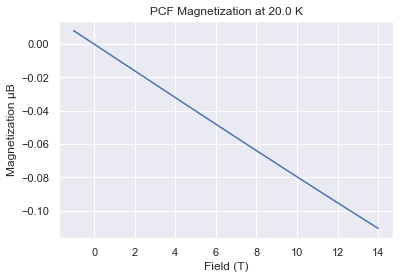

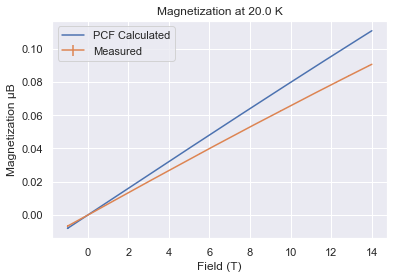

In [9]:
# ## PCF Magnetization
#####################################################################################################################################################################
runs = []
for i in os.listdir(MHDir):
    if i.endswith('.DAT'): #This was a safeguard against a situation arising at an earlier implementation of my code.
        runs.append(i)

mass = getMass(runs[0],who = who)
molweight = 380.15
MHdata = {}
# plt.figure()
for i in runs:
    H, M, Err, T = getData(i,MHDir,who = who, dataType = 'MH')
    M = emuToBohr(M,mass,molweight)
    H = oeToTesla(H)
    Err = emuToBohr(Err,mass,molweight)
    MHdata[T] = [H,M,Err,i]
    # plt.errorbar(H,M, yerr = Err, label = name)

T = '20K'

# samplemass = getMass(MHdata[T][3])
Temp = getTemp(MHdata[T][3], who = who)
H, M, Err, filename = MHdata[T]


#Generate a magnetization curve for comparing results to experiment
magCalc = []
fieldT = np.linspace(0.01,14,1000)

for i in H:
	if LS_on:
		magCalc.append(Pr.magnetization( Temp = Temp, Field = [0, 0, i])[2])		
	else:
		magCalc.append(Pr.magnetization( Temp = Temp, Field = [0, 0, i], ion = ion)[2])

plt.plot(H,magCalc)
plt.xlabel('Field (T)')
plt.ylabel('Magnetization \N{GREEK SMALL LETTER MU}B')
plt.title('PCF Magnetization at {} K'.format(Temp))

plt.figure()
plt.plot(H,-1.*np.array(magCalc), label = 'PCF Calculated')
plt.errorbar(H,M, yerr = Err, label = 'Measured')
plt.xlabel('Field (T)')
plt.ylabel('Magnetization \N{GREEK SMALL LETTER MU}B')
plt.title('Magnetization at {} K'.format(Temp))
plt.legend()
# plt.show()
#####################################################################################################################################################################


## PCF Susceptibility

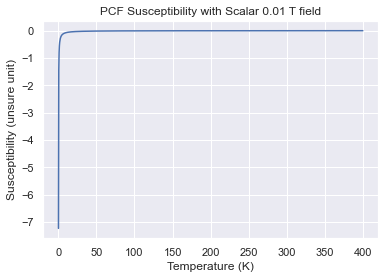

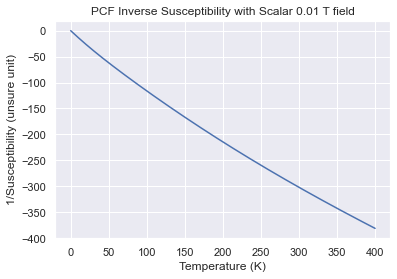

In [10]:

# ## PCF Susceptibility
#####################################################################################################################################################################
runs = []
for i in os.listdir(MTDir):
    if i.endswith('.DAT'): #This was a safeguard against a situation arising at an earlier implementation of my code.
        runs.append(i)


MTdata = {}
# plt.figure()
for i in runs:
    M,H,T,Err,samplemass,measType = getData(i,MTDir, who = who, dataType = 'MT')
    MTdata[measType] = [M,H,T,Err,samplemass]
    # plt.errorbar(H,M, yerr = Err, label = name)

M,H,T,Err,samplemass = MTdata['ZFC']
# samplemass = JT.getMass(MHdata['ZFC'][4])

suscCalc = []
Temp = np.linspace(.1,400,1000)
fieldT = 0.01
deltaField = 0.0001
if LS_on:
	suscCalc = Pr.susceptibility(Temps = Temp, Field = fieldT, deltaField = deltaField)
else:
	suscCalc = Pr.susceptibility(Temps = Temp, Field = fieldT, deltaField = deltaField, ion = ion)
# for i in Temp:
	# suscCalc.append(Pr.susceptibility(i,fieldT,deltaField))

suscCalcI = []
for i in suscCalc:
	suscCalcI.append(1/i)
plt.figure()
plt.plot(Temp,suscCalc)
plt.xlabel('Temperature (K)')
plt.ylabel('Susceptibility (unsure unit)')
plt.title('PCF Susceptibility with Scalar {} T field'.format(fieldT))

plt.figure()
plt.plot(Temp,suscCalcI)
plt.xlabel('Temperature (K)')
plt.ylabel('1/Susceptibility (unsure unit)')
plt.title('PCF Inverse Susceptibility with Scalar {} T field'.format(fieldT))
plt.show()
#####################################################################################################################################################################


## PCF Neutron Spectrum
Define: an energy array that will be used to calculate lineshape; neutron incident energy, Ei (mev); temperature (K); instrument resolution (meV).

Instrument resolution is typically ~3% - 5% of the Ei.

Lineshape fitting would be ideal for determining the CF Hamiltonian; however, nuances arise. If not all magnetic modes are seen at a single Ei then certain scaling has to be taken into account to adjust the intensities of the signal. For this reason we decided to go down the route of fitting to energy levels.

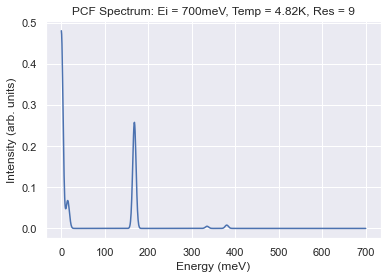

In [11]:



# ## PCF Neutron Spectrum
#####################################################################################################################################################################
energy = np.linspace(.01,700,1000)
Ei = 700
Temp = 4.82
res = 9

CalculatedSpectrum = Pr.neutronSpectrum(energy, Temp=Temp, Ei=Ei, ResFunc = lambda x: res )
# ResFunc = lambda x: 9 if (energy < 200) else 21
plt.figure()
plt.plot(energy,CalculatedSpectrum)
plt.ylabel('Intensity (arb. units)')
plt.xlabel('Energy (meV)')
plt.title('PCF Spectrum: Ei = {}meV, Temp = {}K, Res = {}'.format(Ei,Temp,res))
plt.show()
#####################################################################################################################################################################

# wyb = cef.StevensToWybourne('Ce3+',stev, LS=True)
# print(wyb)


## Convert our fitted Stevens' to Wybourne

In [12]:
# wyb = cef.StevensToWybourne('Ce3+',stev, LS=True)
# print(wyb)